In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Read the CSV files into DataFrames
df_user = pd.read_csv('../2024初賽用開放資料/user_data.csv')
df_exam = pd.read_csv('../2024初賽用開放資料/dp001_exam.csv')
df_prac = pd.read_csv('../2024初賽用開放資料/dp001_prac.csv')
df_review = pd.read_csv('../2024初賽用開放資料/dp001_review.csv')
df_review_plus = pd.read_csv('../2024初賽用開放資料/dp001_review_plus.csv')
df_exam2 = pd.read_csv('../2024初賽用開放資料/dp002_exam.csv')
df_math = pd.read_csv('../2024初賽用開放資料/dp003_math.csv')
df_word = pd.read_csv('../2024初賽用開放資料/dp003_word.csv')



In [2]:
# Load data (assuming df_exam and df_review are already loaded as per previous code)

# Step 1: Calculate correct rate for each review_sn in df_exam
df_exam['correct'] = df_exam['binary_res'].apply(lambda x: 1 if x == '1' else 0 if x == '0' else x)  # Convert '1' to correct = 1, '0' to correct = 0, keep other values as is
review_correct_rate = df_exam.groupby('review_sn')['correct'].mean().reset_index()
review_correct_rate = review_correct_rate.rename(columns={'correct': 'score_rate'})

# Step 2: Merge with df_review to associate each score_rate with user_sn
df_review_score = df_review[['review_sn', 'user_sn']].merge(review_correct_rate, on='review_sn', how='left')

# Step 3: (Optional) Calculate the average score_rate per user
user_score_rate = df_review_score.groupby('user_sn')['score_rate'].mean().reset_index().dropna()

print(user_score_rate.head())


   user_sn  score_rate
1     8634    0.600000
2    11303    0.312500
3    11312    0.887755
4    13328    0.660000
5    14503    0.827273


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Define performance groups based on `score_rate`
# Divide users into Low, Medium, High based on quantiles
user_score_rate['performance_group'] = pd.qcut(user_score_rate['score_rate'], q=3, labels=['Low', 'Medium', 'High'])

# Step 2: Prepare features and labels
# Assuming `behavior_features` contains interaction behaviors and sequence counts
# Merge `user_score_rate` with `behavior_features` to get the features and target together
df_review_plus = df_review_plus.merge(df_review, on='review_sn', how='left')
behavior_features = df_review_plus.groupby('user_sn')['view_action'].value_counts().unstack(fill_value=0)
df_features = behavior_features.merge(user_score_rate[['user_sn', 'performance_group']], on='user_sn', how='left')

# Drop rows with any NaN values in the features and target
df_features = df_features.dropna()
X = df_features.drop(columns=['user_sn', 'performance_group'])
y = df_features['performance_group']

# Step 3: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Train the Random Forest Classifier
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Step 5: Evaluate Model Performance
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High'])

print(f"Classification Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)


Classification Accuracy: 0.59
Classification Report:
              precision    recall  f1-score   support

         Low       0.40      0.33      0.36         6
      Medium       1.00      0.86      0.92         7
        High       0.33      0.50      0.40         4

    accuracy                           0.59        17
   macro avg       0.58      0.56      0.56        17
weighted avg       0.63      0.59      0.60        17



In [4]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train/test split on the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Train the classifier
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Evaluate the model
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High'])

print(f"Classification Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)


Classification Accuracy: 0.67
Classification Report:
              precision    recall  f1-score   support

         Low       0.43      0.60      0.50         5
      Medium       1.00      0.88      0.93         8
        High       0.50      0.40      0.44         5

    accuracy                           0.67        18
   macro avg       0.64      0.62      0.63        18
weighted avg       0.70      0.67      0.68        18



#### Feature Importance Plot

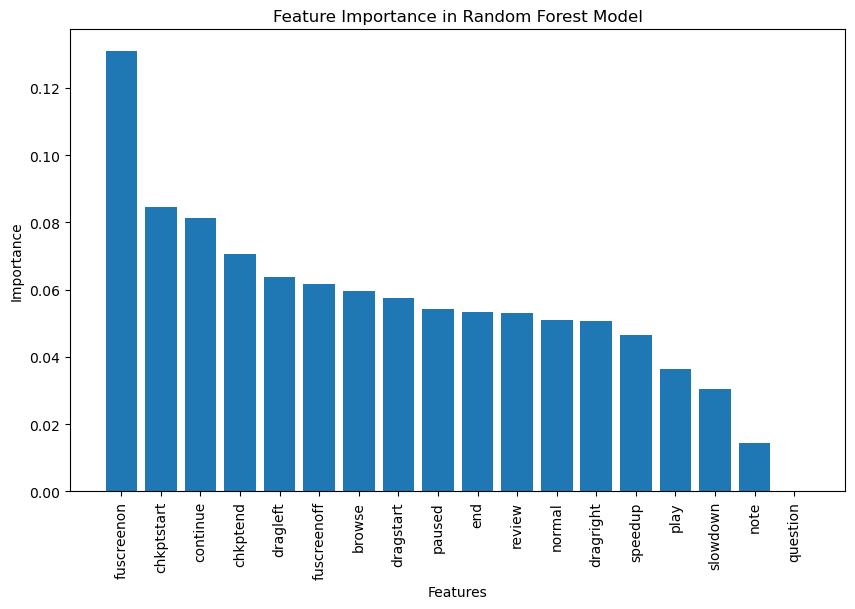

In [6]:
importances = classifier.feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_indices], align="center")
plt.xticks(range(len(importances)), feature_names[sorted_indices], rotation=90)
plt.title("Feature Importance in Random Forest Model")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()


<Figure size 1000x600 with 0 Axes>

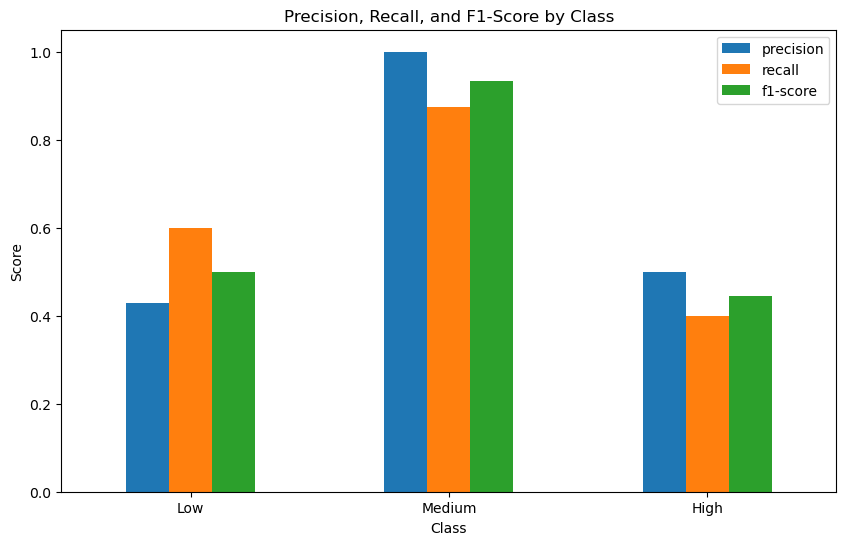

In [7]:
import seaborn as sns
import pandas as pd

# Get classification report as a dictionary
report_dict = classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High'], output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Plot precision, recall, and F1-score
plt.figure(figsize=(10, 6))
report_df[['precision', 'recall', 'f1-score']].iloc[:3].plot(kind='bar', figsize=(10, 6))
plt.title("Precision, Recall, and F1-Score by Class")
plt.xlabel("Class")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()


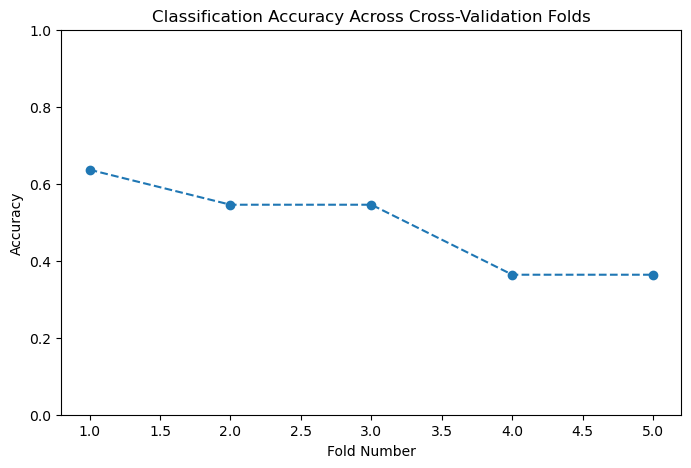

In [8]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(classifier, X, y, cv=5, scoring='accuracy')

# Plot cross-validation accuracy scores
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', linestyle='--')
plt.title("Classification Accuracy Across Cross-Validation Folds")
plt.xlabel("Fold Number")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.show()
